# PJM data processing

The load data are obtained from PJM.

'inst_load.csv' stores actual 5min load, 'very_short_load_frcst.csv' stores forecast 5min load, 'are_control_error.csv' stores the ACE (MW).

unit are MW.

Synthetic demand data from actual PJM datasets, the output is 'd_syn.csv'.

Output contains 3600s of hour 10 and hour 18 in 3600 rows.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
load_inst = pd.read_csv("/Users/jinningwang/Documents/work/andes/jwang/data/inst_load.csv")
load_frct = pd.read_csv("/Users/jinningwang/Documents/work/andes/jwang/data/very_short_load_frcst.csv")
ace0 = pd.read_csv("/Users/jinningwang/Documents/work/andes/jwang/data/area_control_error.csv")

In [3]:
ace = ace0[['datetime_beginning_utc', 'ace_mw']].copy()
ace.columns = ['utc_time', 'ace']
ace = ace[ace["utc_time"].str[:3] == '2/3'].copy()

ace["utc_time"] = pd.to_datetime(ace["utc_time"]).dt.strftime('%H:%M:%S')
# ace["utc_time"] = ace["utc_time"].dt.strftime('%H:%M:%S')

ace.sort_values(by="utc_time", inplace=True)
ace.reset_index(inplace=True, drop=True)

In [4]:
d_inst = load_inst[['datetime_beginning_utc', 'instantaneous_load']].copy()
d_frst0 = load_frct[['forecast_datetime_beginning_utc', 'forecast_load_mw']].copy()

d_inst.columns = ["utc_time", "d_inst"]
d_frst0.columns = ["utc_time", "d_frst"]

d_frst = d_frst0.groupby(by="utc_time", as_index=True, dropna=False).mean()
d_frst.reset_index(level=0, inplace=True)

d_data = pd.merge(d_inst, d_frst, on="utc_time", how="left")
d_data = d_data[d_data["utc_time"].str[:3] == '2/3'].copy()

d_data["utc_time"] = pd.to_datetime(d_data["utc_time"])
d_data["utc_time"] = d_data["utc_time"].dt.strftime('%H:%M:%S')

d_data.sort_values(by="utc_time", inplace=True)
d_data.reset_index(inplace=True, drop=True)

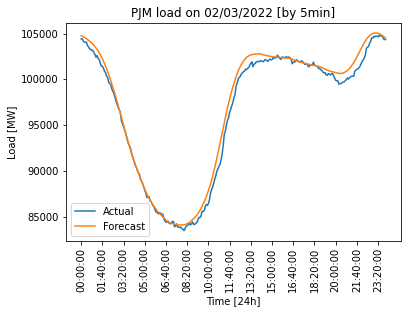

In [5]:
data_in = d_data
x = range(data_in.shape[0])
y1 = data_in["d_inst"]
y2 = data_in["d_frst"]

xt_loc = np.arange(0, data_in.shape[0], step=20)
xt_txt = data_in["utc_time"].iloc[xt_loc]

plt.plot(x, y1, label="Actual")
plt.plot(x, y2, label="Forecast")
plt.xticks(xt_loc, xt_txt, rotation=90)
plt.title("PJM load on 02/03/2022 [by 5min]")
plt.legend()
plt.xlabel("Time [24h]")
plt.ylabel("Load [MW]")
plt.show()

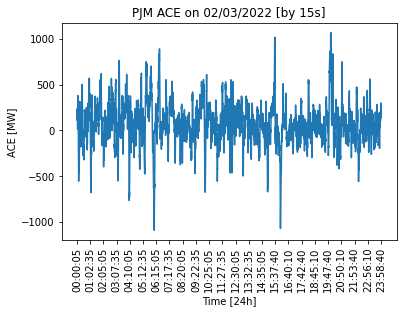

In [6]:
data_in = ace
x = range(data_in.shape[0])
y1 = data_in["ace"]

xt_loc = np.arange(0, data_in.shape[0], step=250)
xt_txt = data_in["utc_time"].iloc[xt_loc]

plt.plot(x, y1, label="ACE")
plt.xticks(xt_loc, xt_txt, rotation=90)
plt.title("PJM ACE on 02/03/2022 [by 15s]")
# plt.legend()
plt.xlabel("Time [24h]")
plt.ylabel("ACE [MW]")
plt.show()

/Users/jinningwang/Documents/work/miniconda3/envs/pp/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


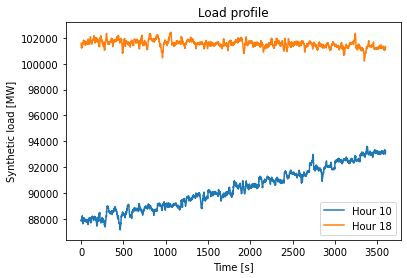

In [7]:
# data integration

str_time = "10:00:00"
end_time = "11:00:00"

d_data[d_data["utc_time"] >= str_time][d_data["utc_time"] < end_time]

ace_p1 = ace.iloc[1000:4600]
ace_p2 = ace.iloc[500:4100]
ace_p2

d10 = np.array([])
d18 = np.array([])
for t in range(12):
    idx0 = 0 + t*300
    idxe = (t+1)*300
    # print(f"str={idx0}, end={idxe}")
    p1 = ace_p1["ace"].iloc[idx0:idxe].values + d_data["d_frst"].iloc[t+120]
    p2 = ace_p2["ace"].iloc[idx0:idxe].values + d_data["d_frst"].iloc[t+216]
    d10 = np.concatenate((d10, p1))
    # print(ace_p1["ace"].iloc[idx0:idxe].values)
    d18 = np.concatenate((d18, p2))

d_syn = pd.DataFrame()
d_syn["t"] = range(3600)
d_syn["h10"] = d10
d_syn["h18"] = d18

plt.plot(d_syn["t"], d_syn["h10"], label="Hour 10")
plt.plot(d_syn["t"], d_syn["h18"], label="Hour 18")
plt.title("Load profile")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Synthetic load [MW]")
plt.show()

In [8]:
d_syn

,t,h10,h18
0,0,87869.165000,101583.283333
1,1,87824.045000,101367.833333
2,2,87901.275000,101266.083333
3,3,87880.345000,101226.863333
4,4,87953.295000,101211.053333
...,...,...,...
3595,3595,93005.996667,101223.678333
3596,3596,93009.316667,101206.778333
3597,3597,93095.116667,101264.408333
3598,3598,93192.816667,101304.158333


In [9]:
d_syn.to_csv('/Users/jinningwang/Documents/work/andes/jwang/case/d_syn.csv', index=False)